In [1]:
%pip install torch torchvision opencv-python numpy pandas matplotlib pillow scipy scikit-learn plotly tqdm flask streamlit twilio requests pyyaml

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
import torch
from scipy.io import loadmat
from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from tqdm import tqdm


In [14]:
train_img_path = "./dataset/part_A_final/train_data/images"
train_gt_path  = "./dataset/part_A_final/train_data/ground_truth"

val_img_path   = "./dataset/part_A_final/test_data/images"
val_gt_path    = "./dataset/part_A_final/test_data/ground_truth"


In [20]:
#Geometry Adaptive Kernel
def generate_adaptive_density(img, points):
    h, w = img.shape[:2]
    density = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density

    tree = KDTree(points)
    distances, _ = tree.query(points, k=4)

    for i, p in enumerate(points):
        y = int(p[1])
        x = int(p[0])

        if x < 0 or x >= w or y < 0 or y >= h:
            continue

        if len(points) > 3:
            sigma = np.mean(distances[i][1:4]) * 0.1
        else:
            sigma = np.mean([h, w]) * 0.01

        sigma = max(1, sigma)

        density[y, x] = 1

        density = gaussian_filter(density, sigma, mode='constant')

    return density


In [21]:
def generate_adaptive_density_map(img, points):
    density = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)

    if len(points) == 0:
        return density

    # If few points → fixed sigma
    if len(points) < 3:
        for p in points:
            density[int(p[1]), int(p[0])] = 1
        return gaussian_filter(density, sigma=3)

    # If many points → adaptive sigma based on nearest neighbors
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(points)
    distances, _ = nbrs.kneighbors(points)

    sigmas = distances[:, 1:4].mean(axis=1) * 0.3

    for i, p in enumerate(points):
        x, y = int(p[0]), int(p[1])
        if x < img.shape[1] and y < img.shape[0]:
            density[y, x] = 1
    
    return gaussian_filter(density, sigma=np.mean(sigmas))


In [22]:
train_imgs = sorted([f for f in os.listdir(train_img_path) if f.endswith('.jpg')])
train_gts  = sorted([f for f in os.listdir(train_gt_path) if f.endswith('.mat')])

def load_sample(idx=0):
    img_file = train_imgs[idx]
    gt_file  = train_gts[idx]

    img_path = os.path.join(train_img_path, img_file)
    gt_path  = os.path.join(train_gt_path, gt_file)

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load .mat ground truth
    gt = loadmat(gt_path)
    points = gt["image_info"][0][0][0][0][0]   # (N,2) points

    # Generate density map
    density = generate_adaptive_density_map(img, points)

    return img, density, points


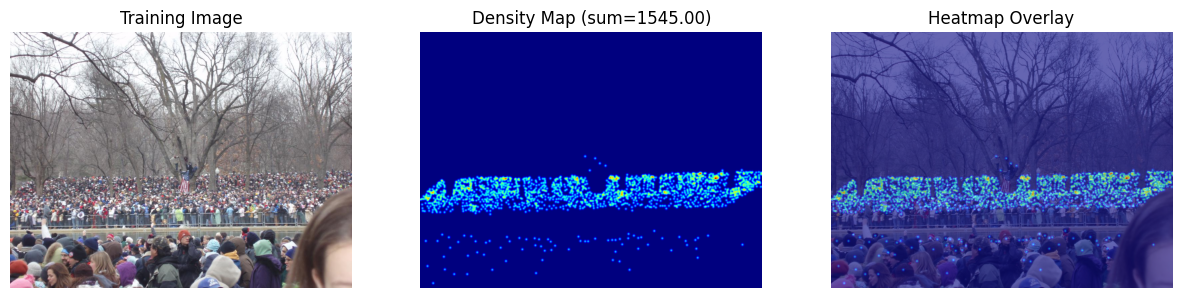

In [23]:
index = 0   # change index to preview different images

img, density, points = load_sample(index)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Training Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(density, cmap='jet')
plt.title(f"Density Map (sum={density.sum():.2f})")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(density, cmap='jet', alpha=0.6)
plt.title("Heatmap Overlay")
plt.axis("off")

plt.show()

In [24]:
#Image normalization
def normalize(img):
    img = img.astype(np.float32) / 255.0

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = (img - mean) / std
    return img


In [25]:
def resize_pair(img, density, new_w=512, new_h=512):
    H, W = img.shape[:2]

    img_resized = cv2.resize(img, (new_w, new_h))

    density_resized = cv2.resize(density, (new_w, new_h))
    density_resized *= (new_h * new_w) / (H * W)

    return img_resized, density_resized


In [26]:
save_img_train = "./processed/train/images"
save_den_train = "./processed/train/density"
#save_img_val   = "./processed/val/images"
#save_den_val   = "./processed/val/density"

os.makedirs(save_img_train, exist_ok=True)
os.makedirs(save_den_train, exist_ok=True)
#os.makedirs(save_img_val, exist_ok=True)
#os.makedirs(save_den_val, exist_ok=True)


In [27]:
train_imgs = sorted(os.listdir(train_img_path))

for img_name in tqdm(train_imgs):
    # Load image
    img_path = os.path.join(train_img_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load GT points
    gt_path = os.path.join(train_gt_path, "GT_" + img_name.replace(".jpg", ".mat"))
    gt = loadmat(gt_path)
    points = gt["image_info"][0][0][0][0][0]

    # Generate adaptive density
    density = generate_adaptive_density(img, points)

    # Resize + Normalize
    img, density = resize_pair(img, density)
    img = normalize(img)

    # Save
    np.save(os.path.join(save_img_train, img_name.replace(".jpg", ".npy")), img)
    np.save(os.path.join(save_den_train, img_name.replace(".jpg", ".npy")), density)


100%|██████████| 300/300 [45:55<00:00,  9.19s/it] 


In [28]:
#For test sets
'''
val_imgs = sorted(os.listdir(val_img_path))

for img_name in tqdm(val_imgs):
    img_path = os.path.join(val_img_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gt_path = os.path.join(val_gt_path, "GT_" + img_name.replace(".jpg", ".mat"))
    gt = loadmat(gt_path)
    points = gt["image_info"][0][0][0][0][0]

    density = generate_adaptive_density(img, points)
    
    img, density = resize_pair(img, density)
    img = normalize(img)

    np.save(os.path.join(save_img_val, img_name.replace(".jpg", ".npy")), img)
    np.save(os.path.join(save_den_val, img_name.replace(".jpg", ".npy")), density)
'''

'\nval_imgs = sorted(os.listdir(val_img_path))\n\nfor img_name in tqdm(val_imgs):\n    img_path = os.path.join(val_img_path, img_name)\n    img = cv2.imread(img_path)\n    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\n    gt_path = os.path.join(val_gt_path, "GT_" + img_name.replace(".jpg", ".mat"))\n    gt = loadmat(gt_path)\n    points = gt["image_info"][0][0][0][0][0]\n\n    density = generate_adaptive_density(img, points)\n    \n    img, density = resize_pair(img, density)\n    img = normalize(img)\n\n    np.save(os.path.join(save_img_val, img_name.replace(".jpg", ".npy")), img)\n    np.save(os.path.join(save_den_val, img_name.replace(".jpg", ".npy")), density)\n'

In [ ]:
#Pytorch dataset loader

from torch.utils.data import Dataset, DataLoader

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img = np.load(os.path.join(self.img_dir, fname))
        den = np.load(os.path.join(self.den_dir, fname))

        img = torch.from_numpy(img).permute(2, 0, 1).float()
        den = torch.from_numpy(den).unsqueeze(0).float()

        return img, den


In [31]:
#create dataset and dataloader
train_dataset = CrowdDataset(save_img_train, save_den_train)
#val_dataset   = CrowdDataset(save_img_val, save_den_val)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
#val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)

print("Train samples:", len(train_dataset))
#print("Val samples:", len(val_dataset))


Train samples: 300
